In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np

#Autoencoders

In [2]:
train_ds = torchvision.datasets.MNIST("./",download=True,train=True,transform=torchvision.transforms.ToTensor())
test_ds = torchvision.datasets.MNIST("./",download=True,train=False,transform=torchvision.transforms.ToTensor())

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=64)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=64)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
def conv_block(inplanes,outplanes,kernel_size=3,stride=1,padding=1):
  return nn.Sequential(
      nn.Conv2d(inplanes,outplanes,kernel_size=kernel_size,stride=stride,padding=padding,bias=False),
      nn.BatchNorm2d(outplanes),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2)
  )

def deconv_block(inplanes,outplanes,kernel_size=4,stride=2,padding=1):
  return nn.Sequential(
      nn.ConvTranspose2d(inplanes,outplanes,kernel_size=kernel_size,stride=stride,padding=padding,bias=False),
      nn.BatchNorm2d(outplanes),
      nn.ReLU(inplace=True),
  )

class Reshape(nn.Module):
  def __init__(self, new_shape):
    super().__init__()
    self.new_shape = new_shape
  def forward(self,x):
    return x.view(self.new_shape)

class AutoEncoderModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        conv_block(1,16),
        conv_block(16,32),
        conv_block(32,64),
        conv_block(64,128),
        nn.Flatten()
    )
    self.decoder = nn.Sequential(
        nn.Linear(128,7*7*32),
        Reshape((-1,32,7,7)),
        deconv_block(32,16),
        deconv_block(16,1),
    )
  def forward(self, x):
    return self.decoder(self.encoder(x))

In [4]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
model = AutoEncoderModel().to(dev)

In [6]:
def evaluate(model, loader, crit):
  model.eval()
  avg_loss = 0
  for x, _ in loader:
    x = x.to(dev)
    o = model(x)
    loss = crit(o,x)
    avg_loss += loss.item()
  avg_loss /= len(loader)  
  return avg_loss

def train_one_epoch(model, train_loader, crit, optim):
  model.train()
  avg_loss = 0
  for x, _ in train_loader:
    optim.zero_grad()
    x = x.to(dev)
    o = model(x)
    loss = crit(o,x)
    avg_loss += loss.item()
    loss.backward()
    optim.step()
  avg_loss /= len(train_loader)
  return avg_loss

def train(model, train_loader, test_loader, crit, optim, epochs = 10):
  for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader,crit, optim)
    test_loss = evaluate(model, test_loader, crit)
    print(f"epoch: {epoch}, train loss: {train_loss}, test loss: {test_loss}")

In [7]:
crit= nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=0.1)
train(model, train_dl, test_dl, crit, optim)

epoch: 0, train loss: 0.07175667958060053, test loss: 0.05959506902345427
epoch: 1, train loss: 0.0504234600216468, test loss: 0.042756052841995934
epoch: 2, train loss: 0.035535336545567266, test loss: 0.02999910257851622
epoch: 3, train loss: 0.027179396333995024, test loss: 0.02428928263200696
epoch: 4, train loss: 0.022896806792870386, test loss: 0.021859294242539982
epoch: 5, train loss: 0.01997547596891615, test loss: 0.01899823133543039
epoch: 6, train loss: 0.018279906381159894, test loss: 0.017561429203932832
epoch: 7, train loss: 0.016980631033709243, test loss: 0.016200408992019428
epoch: 8, train loss: 0.01595327158524061, test loss: 0.015344045907970826
epoch: 9, train loss: 0.015198410379448172, test loss: 0.014630724296305969


In [8]:
model.eval()

AutoEncoderModel(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [ ]:
torch.save(model.state_dict(),"autoencoder_mnist.ckpt")

In [9]:
with torch.no_grad():
  x, _ = next(iter(test_dl))
  o = model(x.to(dev)).cpu()
  encoded_x = model.encoder(x.to(dev)).cpu()

In [10]:
print("encoded:\n",encoded_x)
print(encoded_x.shape)

encoded:
 tensor([[2.8363, 1.1091, 1.1701,  ..., 0.2941, 1.8951, 0.7975],
        [0.8172, 1.7760, 2.8497,  ..., 0.3807, 1.7018, 0.7866],
        [1.9506, 1.3570, 0.4549,  ..., 0.8126, 0.9200, 0.8505],
        ...,
        [1.9549, 1.8771, 1.1860,  ..., 0.9179, 2.3972, 1.3579],
        [1.8222, 1.5154, 1.0363,  ..., 0.6074, 1.6083, 1.0847],
        [1.9341, 1.6804, 1.6387,  ..., 0.6380, 1.3096, 1.4299]])
torch.Size([64, 128])


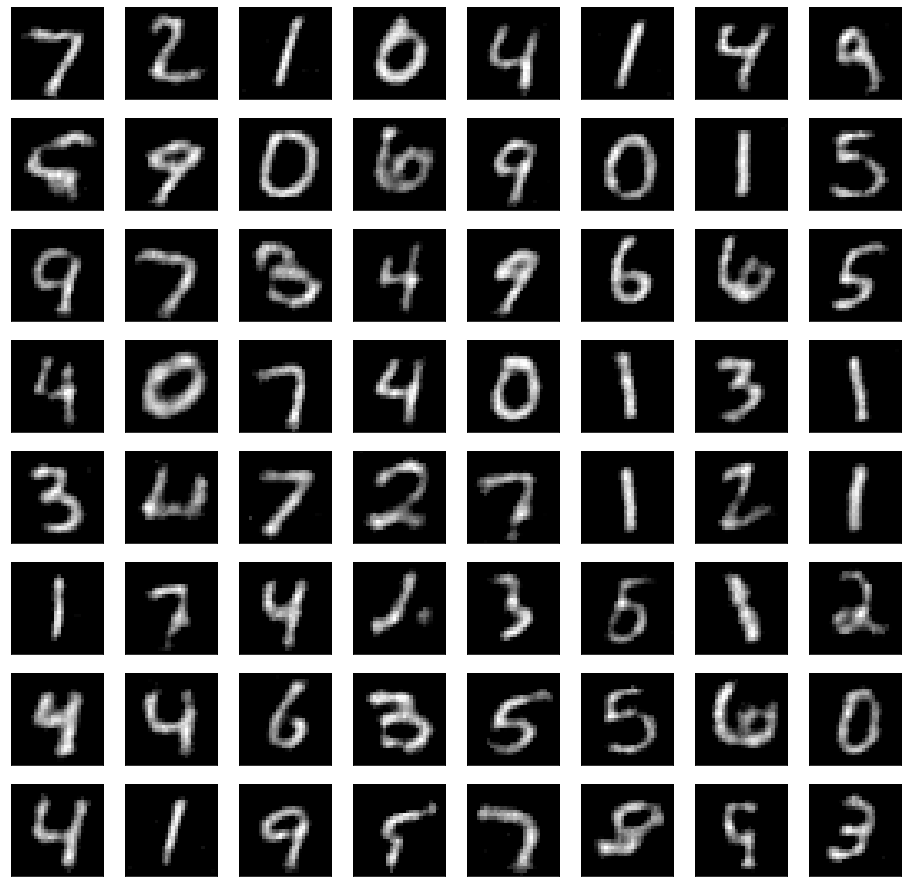

In [11]:
fig, axs = plt.subplots(8,8,figsize=(16,16))
for i in range(64):
  axs[i//8,i%8].imshow(o[i].cpu().detach().numpy().reshape(28,28),cmap="gray")
  axs[i//8,i%8].set_xticks([])
  axs[i//8,i%8].set_yticks([])

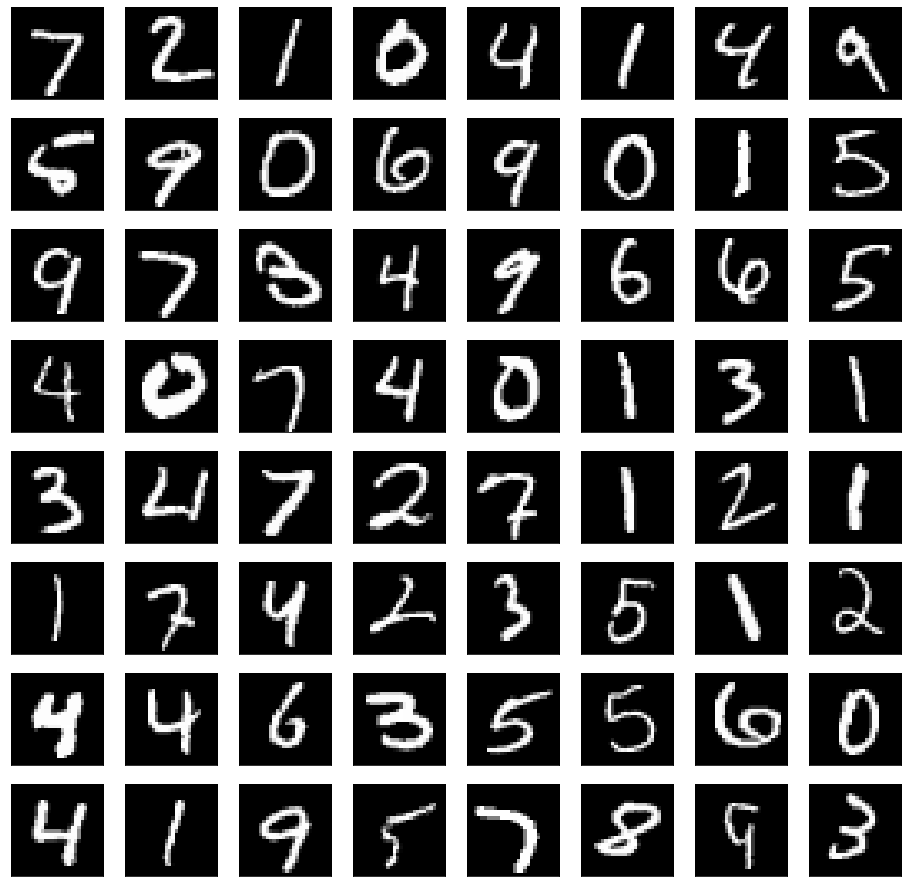

In [12]:
fig, axs = plt.subplots(8,8,figsize=(16,16))
for i in range(64):
  axs[i//8,i%8].imshow(x[i].cpu().detach().numpy().reshape(28,28),cmap="gray")
  axs[i//8,i%8].set_xticks([])
  axs[i//8,i%8].set_yticks([])


# GAN

In [13]:
generator = nn.Sequential(
    nn.Linear(100,7*7*32),
    Reshape((-1,32,7,7)),
    deconv_block(32,16),
    deconv_block(16,1)
).to(dev)

discriminator = nn.Sequential(
    conv_block(1,16),
    conv_block(16,32),
    conv_block(32,32),
    conv_block(32,64),
    nn.Flatten(),
    nn.Linear(64,1)
).to(dev)

In [14]:
crit = nn.BCEWithLogitsLoss()
optim_generator = torch.optim.SGD(generator.parameters(),lr=0.01)
optim_discriminator = torch.optim.SGD(discriminator.parameters(),lr=0.001)

In [15]:
generator.train()
discriminator.train()

for epoch in range(10):
  tot_loss_discriminator = 0
  tot_loss_generator = 0
  
  for x, _ in train_dl:
    x = x.to(dev)
    N, _, _,_ = x.shape
    noise = torch.randn((N,100)).to(dev)
    
    real_labels = torch.ones((N,1)).to(dev)
    fake_labels = torch.zeros((N,1)).to(dev)

    fake_imgs = generator(noise).detach()
    loss_discriminator = crit(discriminator(x),real_labels) + crit(discriminator(fake_imgs), fake_labels)
    tot_loss_discriminator += loss_discriminator.item()
    optim_discriminator.zero_grad()
    loss_discriminator.backward()
    optim_discriminator.step()

    noise = torch.randn((N,100)).to(dev)
    fake_imgs = generator(noise)
    loss_generator = crit(discriminator(fake_imgs), real_labels)
    tot_loss_generator += loss_generator.item()
    optim_generator.zero_grad()
    loss_generator.backward()
    optim_generator.step()
  print(f"loss discriminator:{tot_loss_discriminator/len(train_dl)}, loss generator: {tot_loss_generator/len(train_dl)}")

loss discriminator:0.7560891325412783, loss generator: 1.324425041103668
loss discriminator:0.32332875272199546, loss generator: 2.514440685256458
loss discriminator:0.27177124934346436, loss generator: 3.0572507308442582
loss discriminator:0.5269120569740023, loss generator: 2.2911450108930245
loss discriminator:0.4721658470343425, loss generator: 2.444658618301217
loss discriminator:0.39748437500108025, loss generator: 2.7984330276372846
loss discriminator:0.34785353870534186, loss generator: 3.0248311225857054
loss discriminator:0.29675115186220674, loss generator: 3.2242291434757364
loss discriminator:0.2460986927771238, loss generator: 3.538720327415573
loss discriminator:0.2295038284920553, loss generator: 3.6821042108716866


In [16]:
generator.eval()
o = generator(torch.randn((16,100)).to(dev)).cpu()

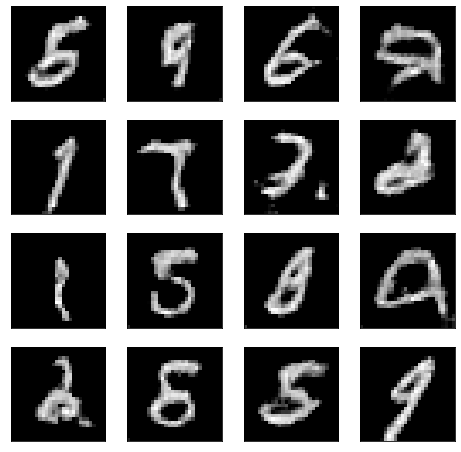

In [17]:
fig, axs = plt.subplots(4,4,figsize=(8,8))
for i in range(16):
  axs[i//4,i%4].imshow(o[i][0].detach().numpy(),cmap="gray")
  axs[i//4,i%4].set_xticks([])
  axs[i//4,i%4].set_yticks([]) 

In [ ]:
torch.save(generator.state_dict(),"generator_mnist.ckpt")
torch.save(discriminator.state_dict(),"discriminator_mnist.ckpt")